# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|
|xgboost|0.8|

**강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com)**

In [10]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys
import xgboost as xgb

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, xgb]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
xgboost 0.80


In [11]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요

다음은 폴더블 폰의 힌지에 들어가는 스프링 내구력을 테스트한 실험 결과이다. 

스프링 측정값과 스프링에 가한 부하 정보와 함께, 테스트 통과/실패 (failure) 결과가 기재되어 있다. 

개발부서는 테스트 비용을 줄이기 위해 failure 여부를 맞추는 모델을 만들고자 한다.

변수명은 보안을 위해 measurement_0과 같이 익명화되었다.

데이터 구성

학습데이터: train_prob.csv, 21,458 rows, 25 columns

테스트데이터: test_prob.csv, 5,112 rows, 24 columns, 

테스트정답셋: test_prob_ans.csv, 5,112 rows, 1 columns


**변수 설명**

|변수명|설명|타입|
|--|--------------|------|
|id|실험 고유 번호|정수형|
|product_code|스프링 코드|범주형|
|loading|스프링에 가한 부하|실수형|
|attribute_0|구성 소재1|범주형|
|attribute_1|구성 소재2|범주형|
|attribute_2|구성 소재3|정수형|
|attribute_3|구성 소재4|정수형|
|measurement_0 ~ 17|측정값 0~17|실수형|
|failure|성공여부|이진형(0, 1)|


# 전처리(Preprocessing)

train_prob.csv를 불러 온다. 이를 **basetable**이라고 한다.

In [12]:
df_basetable = pd.read_csv('train_prob.csv', index_col = 'id')
display(df_basetable.head())
df_basetable.info()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21458 entries, 0 to 26569
Data columns (total 25 columns):
product_code      21458 non-null object
loading           21257 non-null float64
attribute_0       21458 non-null object
attribute_1       21458 non-null object
attribute_2       21458 non-null int64
attribute_3       21458 non-null int64
measurement_0     21458 non-null int64
measurement_1     21458 non-null int64
measurement_2     21458 non-null int64
measurement_3     21146 non-null float64
measurement_4     21016 non-null float64
measurement_5     20893 non-null float64
measurement_6     20818 non-null float64
measurement_7     20692 non-null float64
measurement_8     20605 non-null float64
measurement_9     20469 non-null float64
measurement_10    20399 non-null float64
measurement_11    20278 non-null float64
measurement_12    20171 non-null float64
measurement_13    20063 non-null float64
measurement_14    19976 non-null float64
measurement_15    19855 non-null float64
me

# 단계 1

**basetable**에 measurement_3 ~17 각각의 행이 결측인지 나타내는 파생 변수를 만든다. 

파생 변수는 이진 형식이고, False는 미결측 True는 결측을 의미한다. 

파생 변수의 이름은 measurement 번호에 따라 isna_3 ~ 17로 한다. 

In [13]:
df_basetable = df_basetable.join(
    df_basetable[['measurement_{}'.format(i) for i in range(3, 18)]].isna().rename(
        columns = lambda x: x.replace('measurement', 'isna')
    )
)
df_basetable.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_8,isna_9,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,False,False,False,True,False,False,False
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,False
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,False,False,False,True,False,False,False,False,False,False
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,False
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,False


## 단계 2

이 과제를 맡은 데이터분석가 지희는 measurement_3~17의 결측치 처리 방안을 고민하던 중, 

개발부서에서 measurement_17은 product_code별로 failure를 예측하기 위해 

measurement_3 ~ measurement_9을 다음과 같이 선형 조합하여 생성한 값이라는 정보를 받았다. 

$measurement_{17}= \beta_{0} + \beta_{3}measurement_{3}+\beta_{4}measurement_{4}+...+\beta_{9}measurement_{9}$

이는 즉,

$measurement_{3}= \beta'_{0} + \beta'_{4}measurement_{4}+\beta'_{5}measurement_{5}+...+\beta'_{9}measurement_{9} + \beta'_{17}measurement_{17}$

...

$measurement_{9}= \beta''_{0} + \beta''_{3}measurement_{3}+\beta''_{4}measurement_{4}+...+\beta''_{8}measurement_{8}+\beta''_{17}measurement_{17}$

와 같이 measurement_3 ~ measurement_9의 각 변수들도 나머지 변수들과 선형 관계를 지닌다. 

이 점을 이용하여 대상 변수를 번갈아 가면서 예측 모델을 만들어 최대한 원래 값에 가깝게 복원할 수 있다. 

이러한 반복적인 결측치 복원 방법을 사내 데이터분석 연구소에 문의 했더니 다음과 같은 가이드를 주었다. 

> sklearn 모듈에 아직은 실험 단계이지만, 비슷한 경우에 문제 없이 사용했던 사례가 있어 의견을 드립니다. 
>
> from sklearn.experimental import enable_iterative_imputer 구문을 사용하여 실험 단계인 모듈을 활성화하고, 
>
> sklearn.impute.IterativeImputer를 사용한다면 원하는 결과를 얻을 수 있습니다.

가이드의 내용을 바탕으로 위의 **product_code** 별 measurement3-9, measurement17의 선형 관계를 이용하여,

**basetable**의 measurement_3 ~ 9와 measurement_17의 결측치를 복원하라.


입력 변수] measurement_3 ~ 9, measurement_17 (입력 변수 순서에 유의)

---
**함수가이드**

sklearn.experimental.enable_iterative_imputer

sklearn.impute.IterativeImputer, random_state=123

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [15]:
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
df_basetable[X_imp].isna().sum(axis=1).value_counts()

0    15827
1     4929
2      651
3       50
4        1
dtype: int64

In [6]:
# 방법 1: 반복문
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
# 𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡17=𝛽0+𝛽3𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡3+𝛽4𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡4+...+𝛽9𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡9
imp = IterativeImputer(
    estimator = LinearRegression(fit_intercept = True),
    random_state=123
)
# 가이드의 내용을 바탕으로 위의 product_code 별 measurement3-9, measurement17의 선형 관계
for i in df_basetable['product_code'].unique():
    s_bidx = df_basetable['product_code'] == i
    df_basetable.loc[s_bidx, X_imp] = imp.fit_transform(df_basetable.loc[s_bidx, X_imp])
df_basetable[X_imp].isna().sum().sum()

0

In [16]:
# 방법 2 groupby ~ apply
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
# 𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡17=𝛽0+𝛽3𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡3+𝛽4𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡4+...+𝛽9𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡9
imp = IterativeImputer(
    estimator = LinearRegression(fit_intercept = True),
    random_state=123
)
df_basetable[X_imp] = df_basetable.groupby('product_code')[X_imp].apply(
    lambda x: pd.DataFrame(imp.fit_transform(x), index = x.index, columns = X_imp)
)
df_basetable[X_imp].isna().sum().sum()

0

In [29]:
# 방법 3: groupby ~ apply fit ~ groupby ~ apply transform
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
# 𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡17=𝛽0+𝛽3𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡3+𝛽4𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡4+...+𝛽9𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑚𝑒𝑛𝑡9
def create_imp():
    return IterativeImputer(
        estimator = LinearRegression(fit_intercept = True),
        random_state=123
    )

s_imp = df_basetable.groupby('product_code')[X_imp].apply(
    lambda x: create_imp().fit(x)
)

df_basetable[X_imp] = df_basetable.groupby('product_code')[X_imp].apply(
    lambda x: pd.DataFrame(s_imp.loc[x.name].transform(x), index = x.index, columns = X_imp)
)

## 단계 3

measurement_10~16까지의 결측치는 모두 product_code별 평균으로 대치한다.

In [32]:
# 방법 1
X_mean  = ['measurement_{}'.format(i) for i in range(10, 17)]
df_basetable[X_mean] = df_basetable.groupby('product_code')[X_mean].transform(lambda x: x.fillna(x.mean()))

In [38]:
# 방법 2
df_basetable[X_mean] = df_basetable.groupby('product_code')[X_mean].apply(
    lambda x: x.fillna(x.mean())
).reset_index('product_code', drop=True)

Hint] 전처리 단계에서 보간 결과를 확인해 보기 위한 각 변수의 평균과 표본표준편차.

| |3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|
|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|
|mean|17.796|11.736|17.131|17.506|11.719|19.022|11.434|16.034|19.194|11.734|15.666|16.033|15.051|16.398|701.768|
|std|0.997|0.994|0.994|0.992|0.993|1.005|0.997|1.278|1.579|1.433|1.149|1.461|1.478|1.671|119.180|

열의 이름의 숫자는 measurement_ 번호, 값은 소수점 3째 자리까지 반올림

In [41]:
df_basetable[['measurement_{}'.format(i) for i in range(3, 18)]].agg(
    ['mean', 'std']
).rename(columns=lambda x: x.split('_')[-1]).round(3)

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean,17.796,11.736,17.131,17.506,11.719,19.022,11.434,16.034,19.194,11.734,15.666,16.033,15.051,16.398,701.768
std,0.997,0.994,0.994,0.992,0.993,1.005,0.997,1.278,1.579,1.433,1.149,1.461,1.478,1.671,119.180


# 문제1

(**basetable**을 사용) measurement_3~16까지 결측 여부가 failure에 영향이 있는지를 파악하고, 

failure를 분류하는 데 도움이 될 만한 것은 예측 모델의 입력 변수로 사용하고자 한다. 

이를 위해 전처리 과정에서 뽑아낸 isna_3~16을 활용한다.

n이 3부터 16까지, 즉 measurement_3~16까지 다음의 검정을 수행한다.

$H_0: P(failure=True|measurement_{n}=Missing)=P(failure=True)$

$H_1: P(failure=True|measurement_{n}=Missing) \neq P(failure=True)$

모집단의 $P(failure=True) = 0.2114$


## 단계 1-1

우선, measurement_3으로 위 검정을 시행해보자.

$H_0: P(failure=True|isna_{3}=True)=0.2114$

$H_1: P(failure=True|isna_{3}=True) \neq 0.2114$

으로 바꿀 수 있다.

**basetable**에서 측정한 $P(failure=True|isna_{3}=True)$은 표본수가 충분하여 중심극한정리에 의해 정규분포를 따르는 것은 분석가 간에 이견이 없다고 한다. 

위 검정의 p-value를 구하여 보고 힌트에 주어진 p-value와 비교하여 검정 방법에 문제가 없음을 확인하라.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---

 Hint] p-value는 0.0037(소수점 다섯째 자리에서 반올림하여 넷째 자리까지 표시)


In [54]:
from scipy.stats import norm
# H0가 맞다면 => 𝑃(𝑓𝑎𝑖𝑙𝑢𝑟𝑒=𝑇𝑟𝑢𝑒|𝑖𝑠𝑛𝑎3=𝑇𝑟𝑢𝑒)=0.2114,  failure|isna3=True ~ Bern(p=0.2114) : True => success, positive, 1  
# 측정한  𝑃(𝑓𝑎𝑖𝑙𝑢𝑟𝑒=𝑇𝑟𝑢𝑒|𝑖𝑠𝑛𝑎3=𝑇𝑟𝑢𝑒)은 표본수가 충분하여 중심극한정리에 의해 정규분포
# 𝑃(𝑓𝑎𝑖𝑙𝑢𝑟𝑒=𝑇𝑟𝑢𝑒|𝑖𝑠𝑛𝑎3=𝑇𝑟𝑢𝑒) = (failure=True|isna3=True 수)   / (isna3=True의 표본수)
#                      = (failure=True|isna3=True).sum()  / (isna3=True의 표본수)
# df_basetable.loc[df_basetable['isna_3'], 'failure'].sum() / df_basetable['isna_3'].sum()
#                      = (failure=True|isna3=True).mean()  ~ N(sam_mean_mu, sam_mean_sigma^2)
# 베르누이 분포의 표본 확률 = 표본 평균
sam_mean = df_basetable.loc[df_basetable['isna_3'], 'failure'].mean()
# N(sam_mean_mu, sam_mean_sigma^2) = ?
# failure|isna3=True ~ Bern(p=0.2114) => mu=p, sigma2=p x (1 - p)
p = 0.2114
mu, sigma2 = p, p * (1 - p)
# N(sam_mean_mu, sam_mean_sigma^2) = N(p, sigma^2 / n), n은 표본수
sam_mean_mu = mu
n = df_basetable['isna_3'].sum()
sam_mean_sigma2 = sigma2 / n

Z = -abs((sam_mean - sam_mean_mu) / (sam_mean_sigma2 ** 0.5))
Z, norm.cdf(Z) * 2

(-2.905807189028007, 0.0036630709140241546)

In [56]:
df_basetable.loc[df_basetable['isna_3'], 'failure'].sum()

45

In [57]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(
    count = df_basetable.loc[df_basetable['isna_3'], 'failure'].sum(),
    nobs = df_basetable['isna_3'].sum(),
    value = 0.2114,
    alternative = 'two-sided',
    prop_var = 0.2114
)

(-2.905807189028007, 0.0036630709140241546)

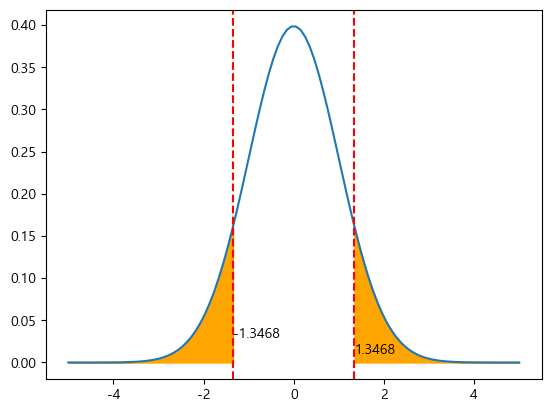

In [51]:
# 표준정규 분포를 이용한 pvalue 도출을 그래프로 설명해봅니다
from scipy.stats import norm
P_true = 0.2114
col = 'isna_{}'.format(4)
P_var = P_true * (1 - P_true)
n_samples = df_basetable[col].sum()
P_missing_true = df_basetable.loc[df_basetable[col], 'failure'].mean()
P_missing_var = P_var / n_samples
P_missing_std = P_missing_var ** 0.5

stat = -abs((P_missing_true - P_true) / P_missing_std)

plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100)))
plt.axvline(stat, color='red', linestyle='--')
plt.text(stat, 0.03, str(stat)[:7])
plt.axvline(-stat, color='red', linestyle='--')
plt.text(-stat, 0.01, str(-stat)[:6])
plt.fill_between(np.linspace(-5, stat, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-5, stat, 100)), color='orange')
plt.fill_between(np.linspace(-stat, 5, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-stat, 5, 100)), color='orange')

plt.show()

## 단계 1-2

measuremenet_3을 포함하여 measurement_4 ~ 16까지 위 검정을 반복하고 

귀무가설을 기각할 수 있는 경우의 p-value의 합을 A라고 한다. (유의 수준은 5%로 한다.)

In [60]:
p = 0.2114
mu, sigma2 = p, p * (1 - p)
sam_mean_mu = mu

ztest = list()
for i in range(3, 17):
    val = 'isna_{}'.format(i)
    sam_mean = df_basetable.loc[df_basetable[val], 'failure'].mean()
    n = df_basetable[val].sum()
    sam_mean_sigma2 = sigma2 / n

    Z = -abs((sam_mean - sam_mean_mu) / (sam_mean_sigma2 ** 0.5))
    ztest.append(
        pd.Series([Z, norm.cdf(Z) * 2], index = ['Z', 'pvalue'], name = val)
    )
df_ztest = pd.DataFrame(ztest)
df_ztest

,Z,pvalue
isna_3,-2.905807,0.003663
isna_4,-1.346824,0.178037
isna_5,-2.221383,0.026325
isna_6,-0.261780,0.793491
isna_7,-0.890904,0.372981
isna_8,-0.698051,0.485145
isna_9,-0.539344,0.589650
isna_10,-0.762200,0.445940
isna_11,-0.103525,0.917546
isna_12,-0.609528,0.542174


In [62]:
# 귀무가설을 기각할 수 있는 경우의 p-value의 합을 A라고 한다. (유의 수준은 5%로 한다.)
display(df_ztest.query('pvalue < 0.05'))
A = df_ztest.query('pvalue < 0.05')['pvalue'].sum()
A

,Z,pvalue
isna_3,-2.905807,0.003663
isna_5,-2.221383,0.026325


0.029988079249523434

## 단계 1-3

검정 결과 귀무가설을 기각할 수 있는 경우는 총 두 건이다. 

해당 파생 변수명의 뒷 자리 번호 순으로 na_1, na_2로 파생 변수를 만들어 **prob1** 데이터셋을 생성하라.

In [63]:
df_prob1 = df_basetable.assign(
    na_1 = lambda x: df_basetable['isna_3'],
    na_2 = lambda x: df_basetable['isna_5']
)
df_prob1.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17,na_1,na_2
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,False,True,False,False,False,False,False
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,False
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,False,True,False,False,False,False,False,False,False,False
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,False
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,False


In [65]:
A, round(A, 3)

(0.029988079249523434, 0.03)

A의 값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오. 

**0.030**

# 문제 2

첫째는 스프링 개발 업체들은 실험이 제품 별로 공정하게 진행이 됐는지를 의문을 가지고 있다.

product_code에 따라 개발 업체가 다르다. 

product_code에 따라서 스프링에 가한 부하(loading)를 동일하게 했는지 조사하라.

둘째는, attribute_0와 attribute_1은 스프링을 구성하는 주요 소재이다. 

failure와는 관계가 없음이 이전에 검증되었다. 

하지만, 이에 대한 재확인 요청을 받아 attribute_0와 attribute_1은 failure와 상관없음을 확인한다.

이를 위해 다음 단계를 수행하라.


## 단계 2-1

**prob1**에서 변수 loading에 결측이 없는 행들을 뽑아 **prob2** 데이터프레임을 만든다.

Hint] prob2의 데이터 수는 21,257 이다.


In [67]:
df_prob2 = df_prob1.loc[df_prob1['loading'].notna()]
df_prob2.shape

(21257, 42)

## 단계 2-2

**prob2**에 변수 loading의 각 행들에 자연 로그 함수를 적용하여 파생 변수 loading_log를 만든다.

In [70]:
df_prob2 = df_prob2.assign(
    loading_log = lambda x: np.log(x['loading'])
)
df_prob2.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17,na_1,na_2,loading_log
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,True,False,False,False,False,False,4.383276
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,4.441356
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,True,False,False,False,False,False,False,False,False,4.411949
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,4.615813
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,5.236761


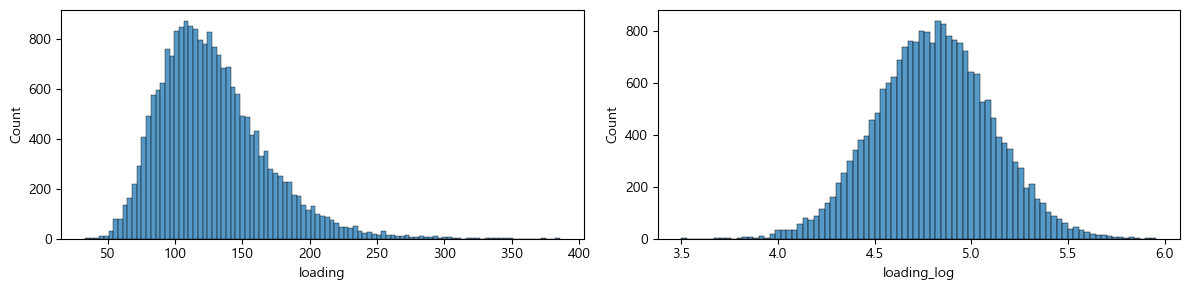

In [71]:
fig, axes = plt.subplots(1, 2, figsize = (12, 3))
sns.histplot(df_prob2, x = 'loading', ax = axes[0])
sns.histplot(df_prob2, x = 'loading_log', ax = axes[1])
plt.tight_layout()
plt.show()

## 단계 2-3

loading_log가 product_code 각각에 대해서 정규성을 지니고 있는지 확인하고자 한다.

이를 위해 product_code 별로 loading_log에 대한 Jarque-Bera로 검정하고, 

검정 결과 정규성을 부정할 수 없는 경우의 product_code의 수를 B라고 한다.(유의 수준: 5%)

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [72]:
df_prob2['product_code'].value_counts()

C    5716
E    5281
B    5209
A    5051
Name: product_code, dtype: int64

In [73]:
# 방법1: 하드코딩
from scipy.stats import jarque_bera
B = 3 # 검정 결과 정규성을 부정할 수 없는 경우의 product_code의 수를 B라고 한다.(유의 수준: 5%)
(
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'C', 'loading_log']),
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'E', 'loading_log']),
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'B', 'loading_log']),
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'A', 'loading_log']), B
)

(Jarque_beraResult(statistic=7.536229242478234, pvalue=0.023095566154546443),
 Jarque_beraResult(statistic=0.04839464502051384, pvalue=0.9760930856160965),
 Jarque_beraResult(statistic=0.6168837955943998, pvalue=0.7345906322931469),
 Jarque_beraResult(statistic=1.467731470333654, pvalue=0.4800496537264637),
 3)

In [78]:
# 방법2
from scipy.stats import jarque_bera

df_jarque = df_prob2.groupby('product_code')['loading_log'].apply(
    lambda x: pd.Series(jarque_bera(x), index = ['stat', 'pvalue'])
).unstack()
display(df_jarque)
B = (df_jarque['pvalue'] >= 0.05).sum()
B

,stat,pvalue
product_code,,
A,1.467731,0.480050
B,0.616884,0.734591
C,7.536229,0.023096
E,0.048395,0.976093


3

## 단계 2-4

loading_log 변수를 product_code로 구분했을 때, 

등분산성을 보이는지 Bartlett 검정을 통해 확인한다.

검정 결과에서 p-value를 C라고 한다.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [80]:
# 방법 1: 하드코딩
from scipy.stats import bartlett
result_2_4 = bartlett(
    df_prob2.loc[df_prob2['product_code'] == 'A', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'B', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'C', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'E', 'loading_log'],
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

In [85]:
# 방법 2: groupby ~ agg list => list unpacking

def lu(*args):
    print(len(args), args)

lu(1, 2, 3)
lu([1, 2, 3])
# list unpacking은 * 연산자를 사용하면 됩니다.
lu(*[1, 2, 3])

3 (1, 2, 3)
1 ([1, 2, 3],)
3 (1, 2, 3)


In [95]:
result_2_4 = bartlett(
    *df_prob2.groupby('product_code')['loading_log'].agg(list)
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

## 단계 2-5

product_code에 대한 분산분석(ANOVA)을 통해서 loading_log 평균에 차이가 있는지 검정한다.

그 결과 중 p-value를 D라고 한다.

---

**함수 가이드**

 scipy.stats 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [98]:
from  scipy.stats import f_oneway
result_2_5 = f_oneway(
    *df_prob2.groupby('product_code')['loading_log'].agg(list)
)
D = result_2_5.pvalue
result_2_5, D

(F_onewayResult(statistic=0.37177284134760413, pvalue=0.7733782072320899),
 0.7733782072320899)

## 단계 2-6

카이제곱검정을 통해 attribute_0, attribute_1의 결합값이 failure와 연관이 있는지 조사하라. 

attribute_0, attribute_1의 결합값의 의미 attribute_0=material_7, attribute_1=material_8 이라면, 이 둘의 결합값은
matertial_7material_8를 의미한다.

(유의 수준 1%) 연관이 있다면 E값은 1 없으면 0으로 한다.

---

**함수 가이드**

 scipy.stats.chi2_contingency, correction=False
 
 문제 지시사항 외 Default 값 사용
 
---


In [105]:
from scipy.stats import chi2_contingency

result_2_6 = chi2_contingency(
    pd.crosstab(
        index = df_prob2['attribute_0'] + df_prob2['attribute_1'],
        columns = df_prob2['failure']
    )
    , correction=False
)
result_2_6

(7.0400463075335615,
 0.029598749837407304,
 2,
 array([[4106.03584702, 1102.96415298],
        [4162.79042198, 1118.20957802],
        [8487.17373101, 2279.82626899]]))

In [107]:
# (유의 수준 1%) 연관이 있다면 E값은 1 없으면 0으로 한다.
# H0: 독립 => 연관 X => 0, H1: 독립 X => 연관 O => 1
E = 0 if result_2_6[1] >= 0.01 else 1
E

0

In [108]:
B + C + D + E, round(B + C + D + E, 2)

(4.360721516561858, 4.36)

B + C + D + E의 값을 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하시오.

**4.36**

# 문제 3

로지스틱 회귀모델로 수치형 변수 measurement_0 ~ 17, 

loading과 이진형인 na_1, na_2 중에서 최적의 성능을 보이는 입력 변수들을 찾고자 한다.


## 단계 3-1

**prob1**을 복사하여 **prob3**을 만든다. loading의 결측치는 loading의 평균으로 대치한다.  

In [109]:
df_prob3 = df_prob1.assign(
    loading = df_prob1['loading'].fillna(df_prob1['loading'].mean())
)
df_prob3['loading'].isna().sum()

0

## 단계 3-2: 
    
**prob3**을 80%는 학습데이터 **prob3_train**으로 20%는 테스트데이터 **prob3_test**로 나눈다. 

**prob3_train**의 failure가 1인 비율과 **prob3_test**의 failure가 1의 비율을 동일하게 한다.


---

**함수 가이드**

 sklearn.model_selection.train_test_split, random_state=123, 
 
 train과 test의 failure의 비율은 stratify 매개 변수를 이용하여 맞춘다.
 
 문제 지시사항 외 Default 값 사용
 
---

In [116]:
from sklearn.model_selection import train_test_split
df_prob3_train, df_prob3_test = train_test_split(
    df_prob3, train_size = 0.8, stratify = df_prob3['failure'], random_state=123,
)
df_prob3_train, df_prob3_test = df_prob3_train.copy(), df_prob3_test.copy()

In [115]:
pd.concat([
    df_prob3_train['failure'].value_counts(normalize = True).rename('train'),
    df_prob3_test['failure'].value_counts(normalize = True).rename('test')
], axis=1)

,train,test
0,0.788535,0.788677
1,0.211465,0.211323


## 단계 3-3

**prob3_train**의 수치형 입력 변수 loading, measurement_0 ~ 17을 표준 정규화한다. 

**prob3_train**의 표준 정규화 설정으로 **prob3_test**의 loading, measurement_0 ~ 17에도 적용한다. 

표준화 처리한 **prob3_train**과 **prob3_test**는 문제 4와 문제 5에서 사용한다.


---

**함수 가이드**

 sklearn.preprocessing 제공 기능 활용, 
 
 문제 지시사항 외 Default 값 사용
 
---


In [118]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_std = ['loading'] + ['measurement_{}'.format(i) for i in range(18)]
df_prob3_train[X_std] = std_scaler.fit_transform(df_prob3_train[X_std])
df_prob3_test[X_std] = std_scaler.transform(df_prob3_test[X_std])

## 단계 3-4
    
로지스틱 회귀모델을 사용하여 loading, measurement_0~17과 na_1, na_2를 입력 변수로 하여 **prob3_train**을 학습한다. 

로지스틱 회귀모델을 **prob3_test**로 성능을 측정한 값을 A라고 한다.

입력 변수: loading, measurement_0~17, na_1, na_2

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---

**함수 가이드**

 sklearn.linear_model.LogisticRegression, solver='lbfgs', 문제 지시사항 외 Default 값 사용
 
 sklearn.metrics.roc_auc_score
 
---

## 단계 3-5

로지스틱 회귀모델을 웨퍼(Wrapper)로 사용하고, loading, measurement_0 ~ 17, na_1, na_2를 후보 입력 변수로 한다. 

전진 선택법을 사용하여 이 후보 입력 변수 중에서 최적의 성능을 보이는 입력 변수의 조합을 찾는다. 

전진 선택법의 선택 기준은 **prob3_train**을 대상으로 5겹 층화교차검증(5-Fold stratified cross validation)의 성능 측정 결과를 기준으로 한다. 

전진 선택 과정에서 선택했던 변수를 제외하지 않는다. 

입력 변수: 본 단계 요건 참고

대상 변수: failure 

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

mlxtend.feature_selection.SequentialFeatureSelector

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

문제 지시사항 외 Default 값 사용

---

## 단계 3-6

단계 3-5에서 찾은 최적의 입력 변수 조합으로 로지스틱 회귀모델을 사용하여 **prob3_train**을 학습하고 

**prob3_test**로 성능을 측정한 값을 B라고 한다.

입력 변수: **단계 3-5**에서 도출한 최적의 입력 변수 조합

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수 가이드**

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

문제 지시사항 외 Default 값 사용

---

A-B값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오


# 문제 4

차원 축소 기법을 통한 데이터의 특성을 파악하고, 또한 failure 분류 성능을 높힐 만한 요소를 살펴 본다. 

measurement_0 ~ 17를 변수셋을 **X_4**로 지정한다.

첫째로, loading을 제외하고, 변수셋 **X_4**을 입력으로 failure를 대상 변수로 Linear Discrimant Analysis(LDA) 모델을 만든다. 

True/False 이진 변수인 failure를 분류한다는 점에서 LDA 모델은 변수셋 **X_4**를 한 개의 경계점으로 

failure를 최대한 정확하게 구분하도록 하나의 연속형 변수로 변환한다. 

스프링의 내구력이 높을 수록 failure 확률이 낮아진다면, LDA 변환값은 스프링의 내구력을 나타낸다라고 할 수 있다.

실험에서 스프링에 가한 부하(loading)와  LDA 변환값의 상관도를 측정하여, 

변수셋 **X_4** 에서 예상되는 내구력이 스프링에 따라 부하(loading)의 반영 정도를 가늠한다.

둘째로, PCA를 사용하여 차원 감소로 failure 분류 성능에 얼마나 효과가 있을지 살펴본다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준 정규화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.


## 단계 4-1

**prob3_train**에서 변수셋 **X_4**를 입력으로 failure를 대상 변수로 하여 LDA(Linear Discriminant Analysis) 모델을 학습한다. 

변수셋 **X_4**의 **prob3_train**에서의 LDA의 변환값과 loading과 스피어만 상관도 (spearman correlation)의 p-value를 구하여 A라고 한다.

입력 변수] 변수셋 **X_4**, 입력 변수의 순서는 measurement_ 이후 숫자의 오름차순

대상 변수] failure

---
**함수가이드**

sklearn.discriminant_analysis 제공 기능 활용

scipy.stats.spearmanr

문제 지시사항 외 Default 값 사용

---

## 단계 4-2

**prob3_train**에서 measurement_0 ~ 17을 대상으로 주성분분석(Principal Component Analysis, PCA) 모델을 학습한다. 

분산 설명율이 높은 순으로 주성분 변환한 변수명을 pca_0 ~ 17하여 **prob3_train**에 추가하여 **prob4_train**을 만든다. 

**prob3_test**에 **prob3_train**를 학습했던 PCA 모델로 동일한 방법으로 pca_0 ~17 파생 변수를 추가하여 **prob4_test**를 만든다.

입력 변수] 변수셋 **X_4**, 입력 변수의 순서는 measurement_ 이후 숫자의 오름차순

---
**함수가이드**

sklearn.decomposition.PCA, random_state=123

문제 지시사항 외 Default 값 사용

---


## 단계 4-3

초기에 loading을 입력 변수로 하여 **prob4_train**을 학습하고, **prob4_test**에 대한 성능을 측정한다.

여기에 pca_0에서 pca_17까지 입력 변수를 하나씩 추가 하면서, 

즉 분산 설명율이 높은 순으로 컴포넌트를 하나씩 추가하여 **prob4_train**을 학습하고 **prob4_test**의 성능을 측정 했을 때, 

최적의 성능을 보인 컴포넌트들의 분산 설명율의 합을 B라고 한다. (만일 없다면 B = 0이다.)

입력 변수: 설명 참고

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

sklearn.linear_model.LogisticRegression, solver='lbfgs'

---

A + B를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.


# 문제 5

랜덤포레스트 분류기(Random-Forest Classifier)의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색하고자 한다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준 정규화 과정을 거친) 과정을 거친 **prob3_train**과 **prob3_test**를 사용한다.

## 단계 5-1

sklearn에서 제공하는 랜덤포레스트 분류기(Random-Forest Classifier)의 하이퍼 파라미터 중 

n_estimators, max_depth 그리고 min_samples_split의 최적 조합을 탐색한다. 

탐색 값은 아래에 제공한 하이퍼 파라미터의 모든 조합이다. 

**prob3_train**을 대상으로 5-겹 층화교차검증(5-fold stratified cross validation)으로 성능 측정 결과를 기준으로 하이퍼 파라미터를 선택한다.

  - n_estimators: [5, 10, 15]

  - max_depth: [5, 6, 7]
  
  - min_samples_split: [256, 512]

Hint] 모든 하이퍼 파라미터의 조합의 수는 18개이다

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

itertools.product 필요시 사용

sklearn.model_selection.cross_val_score 필요시 사용

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True,

sklearn.model_selection.GridSearchCV, iid = False 필요시 사용

sklearn.metrics.roc_auc_score 필요시 사용

---

## 단계 5-2

단계 5-1에서 구한 최적 하이퍼 파라미터로 설정한 랜덤포레스트 분류기(Random-Forest Classifier)를 사용하여 **prob3_train**을 학습하고, 

**prob3_test**로 성능 측정한 결과를 A라고 한다.

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

sklearn.metrics.roc_auc_score

---


A값을 소수점 넷째 자리에서 반올림하여 3째 자리까지 출력하시오.

